Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Computing pairwise distances...
Computing P-values for point 0 of 2500...


/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:281: ComplexWarning: Casting complex values to real discards the imaginary part


Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386597
Iteration 10: error is 23.512747
Iteration 20: error is 20.624432
Iteration 30: error is 17.752957
Iteration 40: error is 16.676113
Iteration 50: error is 16.348789
Iteration 60: error is 16.225144
Iteration 70: error is 16.126785
Iteration 80: error is 16.018307
Iteration 90: error is 15.949116
Iteration 100: error is 15.900372
Iteration 110: error is 2.315557
Iteration 120: error is 2.087016
Iteration 130: error is 1.903593
Iteration 140: error is 1.762945
Iteration 150: error is 1.653822
Iteration 160: error is 1.568204
Iteration 170: error is 1.499476
Iteration 180: error is 1.443557
Iteration 190: error is 1.397164
Iteration 200: error is 1.358152
Iteration 210: error is 1.325178
Iteration 220: error is 1.296996
Iteration 230: error is 1.272730
Iteration 240: error is 1.25169

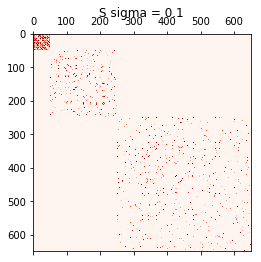

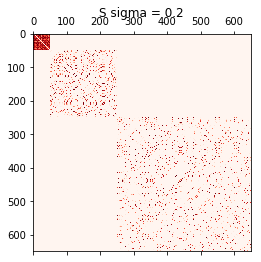

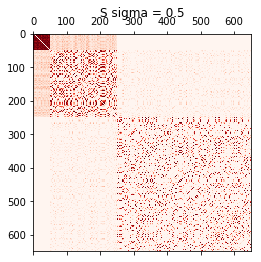

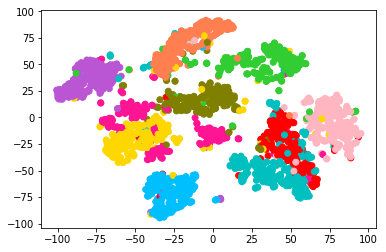

In [2]:
# -*- coding: utf-8 -*-
"""

 Stat 202A 2018 Fall - Final Project
 Author: Xiaohan Wang
 Date : 12/15/2018

 Description: This is the final project for STAT 202A 2018 Fall. 
 Two functions are required, spectual clustering and t-SNE.

 INSTRUCTIONS: Please fill in the missing lines of code
 only where specified. You can modify any line in the function except the
 function names, function inputs or outputs. 
 You can add examples in "if __name__ == '__main__':"
 (in the "Optional examples" section). However, DO NOT LEAVE 
 CODE OUTSIDE ANY FUNCTION.
 
 I will import your code, if it is outside of any function, 
 it will run during import and led to error making you got 
 CE(Compile error) which is zero score. You can do partial score
 HOWEVER, make sure it is runable. (e.g. even you do not run t-SNE, 
 if you do not comment out all t-SNE function, you may get CE in spectral
 Clustering because I cannot import your python files.)

 Do not use any of Python's built in functions for matrix 
 inversion or for linear modeling (except for debugging or 
 in the optional examples section).

 
"""

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

########################################################
#           Function 1 : Spectral Clustering
########################################################

def s(x, y, sigma=1.0):
    return np.exp(-1/(2 * sigma**2) * np.sum((x - y)**2))

def create_S(X, s, eps=1.0e-50):

    ################################
    # TODO (1) implement
    # (1) note, s(x,y) is a function
    # (2) note, set S[i,j] = 0 if s(x,y) < eps
    ################################

    n = X.shape[0]
    S = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                S[i, j] = 0
                continue
            S_ij = s(X[i], X[j])
            if S_ij < eps:
                S_ij = 0
            S[i, j] = S_ij
    
    return S


def create_L(X, s):

    ################################
    # TODO (2) implement
    ################################

    n = X.shape[0]
    S = create_S(X, s)
    D = np.zeros((n, n))
    
    for j in range(n):
        D[j, j] = 1 / np.sqrt(np.sum(S[:, j]))
    
    L = np.dot(D, np.dot(S, D))
    return L


def create_Y(X, s, num_eigs=2):

    ################################
    # TODO (3) implement
    # * Please use your own eigen_decomposition 
    ################################
    
    eigen_value, eigen_vector = np.linalg.eig(create_L(X, s))
    eigen_vector = eigen_vector[:, eigen_value.argsort()[::-1]]
    Y = eigen_vector[:, :num_eigs]

    return Y


def k_means(X, k=2, tol=1e-6, max_iter=300, break_limit=5, num_restarts=10):

    ################################
    # TODO Write comments for k_means.
    #  Already implemented, do not need to modify the code.
    ################################
    n, p = X.shape
    performances = np.zeros(num_restarts)  # store performances in num_restarts k-means
    cluster_array = np.zeros((n, num_restarts)) # store cluster result in num_restarts k-means

    for t in range(num_restarts):  # for each k-means process

        centroids = np.zeros((k, p))  # randomly select k start centroids
        shuffle_X = shuffle(X)
        for i in range(k):
            centroids[i] = shuffle_X[i]

        distances = np.zeros(max_iter)
        break_count = 1

        for iter in range(max_iter):  # there are at most max_iter rounds in each k-means process
            cluster_membership = np.zeros(n)  # cluster each X_i to specific group according to the distance
            for i in range(n):  # for each X_i
                dist_vec = np.zeros(k)
                for j in range(k):  # for each group
                    dist_vec[j] = np.sum((X[i, :] - centroids[j, :])**2)
                cluster_membership[i] = np.argmin(dist_vec)  # select the closest centroid
            cluster_membership = cluster_membership.astype(int)

            for i in range(k): # update position of each centroid (the mean position of each group)
                centroids[i] = np.mean(X[cluster_membership == i, :], axis=0)

            ind_dist = np.zeros(n)  # calculate sum of distance as performance
            for i in range(n):  # for each X_i, calculate the distance to its centroid
                ind_dist[i] = np.sum(
                    (X[i, :] - centroids[cluster_membership[i], :])**2)
            distances[iter] = np.sum(ind_dist**2)

            distance_difference = np.sum(
                (distances[iter] - distances[iter - 1])**2)
            break_count = break_count + 1 if distance_difference < tol else 1  # if dis < tol, break_count plus 1

            if break_count >= break_limit:  # if there are break_limit continuous iterations 
                break                       # with satisfied sum of distances, then break current k-means process

        cluster_array[:, t] = cluster_membership
        performances[t] = distances[iter]

    best_iteration = np.argmin(performances)  # select final cluster result with best performance (min sum of distances)
    final_clusters = cluster_array[:, best_iteration]

    return final_clusters

def spectral_clustering(X, s, num_eigs=2, k=2):

    Y = create_Y(X, s, num_eigs)
    labels = k_means(Y, k)
    return Y, labels

def test_problem1():
    np.random.seed(1)

    def xy(eta, n):

        theta = np.random.uniform(0, 2 * np.pi, n)
        x = eta * np.cos(theta) + np.random.normal(0, 0.05, n)
        y = eta * np.sin(theta) + np.random.normal(0, 0.05, n)
        return x, y

    sigmas = [0.1, 0.2, 0.5, 1.0]
    num_eigs_list = [2**1, 2**2, 2**3, 2**4]

    x0, y0 = xy(0.1, 50)
    x1, y1 = xy(1.0, 200)
    x2, y2 = xy(2.0, 400)

    x = np.concatenate((x0, x1, x2), axis=0)
    y = np.concatenate((y0, y1, y2), axis=0)
    X = np.transpose(np.vstack((x, y)))

    def create_s(sigma): return lambda x, y: s(x, y, sigma=sigma)

    for sigma in sigmas:
        fig, ax = plt.subplots()
        ax.matshow(create_S(X, create_s(sigma)), cmap=plt.cm.Reds)
        plt.title('S sigma = {}'.format(sigma))
    for sigma in sigmas:
        E1, Z1 = np.linalg.eig(create_L(X, create_s(sigma)))
        Z1 = Z1[:, E1.argsort()[::-1]]
        plt.clf()
        plt.plot(Z1[:, 1])
        plt.title('Eigenvector 1 sigma = {}'.format(sigma))
        plt.savefig("Final_P1_Eigenvector1_%d.png" % (sigma*10))
        plt.clf()
        plt.plot(Z1[:, 2])
        plt.title('Eigenvector 2 sigma = {}'.format(sigma))
        plt.savefig("Final_P1_Eigenvector2_%d.png" % (sigma*10))
        plt.clf()

    plt.scatter(x0, y0, c='r', marker='x')
    plt.scatter(x1, y1, c='b', marker='o')
    plt.scatter(x2, y2, c='g', marker='o')
    plt.title('True classes')
    plt.savefig("Final_P1_True_Class.png")
    plt.clf()

    # Plot spectral_clustering results
    for num_eigs in num_eigs_list:
        for sigma in sigmas:
            Y, class_pred = spectral_clustering(X, create_s(sigma), k=3, num_eigs=num_eigs)
            plt.scatter(x[class_pred == 0], y[class_pred == 0], c='r', marker='x')
            plt.scatter(x[class_pred == 1], y[class_pred == 1], c='b', marker='o')
            plt.scatter(x[class_pred == 2], y[class_pred == 2], c='g', marker='o')
            plt.title('Spectral clustering results sigma = {}, num(eigs) = {}'.format(sigma, num_eigs))
            plt.savefig("Final_P1_matrix_%d_%d.png" % (num_eigs, sigma*10))
            plt.clf()

    # Plot kmeans results 
    kmeans_pred = k_means(X, k=3)
    plt.scatter(x[kmeans_pred == 0], y[kmeans_pred == 0], c='r', marker='x')
    plt.scatter(x[kmeans_pred == 1], y[kmeans_pred == 1], c='b', marker='o')
    plt.scatter(x[kmeans_pred == 2], y[kmeans_pred == 2], c='g', marker='o')
    plt.title('K-means clustering results')
    plt.savefig("Final_P1_kmean_result.png")
    plt.clf()



########################################################
#           Function 2 : t-SNE
########################################################


def Hbeta(D=np.array([]), beta=1.0):

    # Calculate P vector and perplexity score.
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):

    # Compute the conditional probability P(j|i)
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i + 1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i + 1:n]))] = thisP

    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):

    # Apply PCA on X.
    n = X.shape[0]
    X = X - np.tile(np.mean(X, 0), (n, 1))
    value, vector = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, vector[:, 0:no_dims])
    
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):

    # This is the main t-SNE method function. It does the algorithm by,
    # 1. Run PCA by pca() and choose the real part.
    # 2. Initialize the parameter and compute the conditional probability.
    # 3. Start iteration to compute h

    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # 1. Run PCA by pca().
    X = pca(X, initial_dims)

    # 2. Initialize the parameter and compute the conditional probability.
    # Codes are for referance only.
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Computes conditional probability p(j|i) based on equation (1) in paper
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4
    P = np.maximum(P, 1e-12)

    # 3. Start iteration to compute h

    for iter in range(max_iter):

        # 3.1 Calculate Q based on current h ($h_0$ is random vectors).
        # Compute pairwise affinities
        sum_y = np.sum(np.square(Y), 1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_y).T, sum_y))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i,:] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # 3.2 Use gradient descent with momentum to minimize the KL divergence.

        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4
            
    return Y

def test_problem2():

    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = np.loadtxt("mnist2500_X.txt")
    labels = np.loadtxt("mnist2500_labels.txt")
    Y = tsne(X, 2, 50, 20.0)
    colormap=['deepskyblue', 'coral', 'limegreen', 'gold', 'c', 'deeppink', 'mediumorchid', 'lightpink', 'olive', 'red']
    plt.scatter(Y[:, 0], Y[:, 1], c=[colormap[i] for i in labels.astype(int)])
    plt.savefig("Final_P2_scatter.png")

if __name__ == '__main__':

    test_problem1()
    test_problem2()

    # Optional examples
    
